In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
You should consider upgrading via the '/opt/ohpc/pub/apps/python/3.8.12/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from GridSearch import GridSearch
import cv2

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

In [35]:
PATH = '/groups/francescavitali/eb2/subImages_slide299/H&E' # has 506 images
BATCH_SIZE = 4 # make sure divisble by 404: 1, 2, 4, 101, 202, 404

tensor_transform = transforms.ToTensor()

dataset = datasets.ImageFolder(PATH, 
                               transform = tensor_transform) #loads the images

train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                           [404,51,51],# 80%, 10%, 10%
                                                           generator=torch.Generator(device=device))

loader = torch.utils.data.DataLoader(dataset = test_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [36]:
model = AE_CNN(64,128).to(device)

model.load_state_dict(torch.load('./models/model_gs.pth')) # loading best model state
model.load_state_dict(torch.load('./models/Copy Models/model_gs_3-28-2024.pth'))

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder

In [37]:
outputs = []
model.eval()
with torch.no_grad():
    for(img, _) in loader: 
        img = img.to(device)
        outputs.append((img, model(img)))

In [38]:
import numpy as np

In [50]:
accuracy = []
for tup in outputs:
    inp, recon = tup
    diff = np.abs(inp.cpu().numpy().astype(float) - recon.cpu().numpy().astype(float)) 
    accuracy.append(diff)

In [42]:
accuracy = accuracy[0, ...]

In [53]:
accuracy[0].shape

(1, 3, 299, 299)

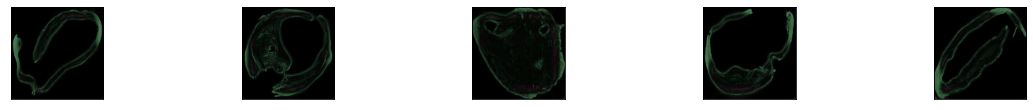

In [56]:
amt = 5
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = accuracy[k][0, ...]
    #img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

In [157]:
total_acc = 0
for img in accuracy:
    img = img[0,...]
    bad_loc = np.argwhere(img > 0.02).tolist()
    total_acc += len(bad_loc)/ (3*299*299)

In [158]:
acc = total_acc # instance, no reference
acc = (1-acc/len(accuracy))*100
print(f'Percent Correct: {acc:.2f}%')

Percent Correct: 66.71%
